In [ ]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from submission import Controller
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation, Camera
from tqdm import trange




timestep = 1e-4
debug = True
level = 4
seed = 45

fly = CobarFly(
    debug=debug,
    enable_vision=True,
    render_raw_vision=False,
)

if level <= 1:
    arena = levels[level](fly=fly, seed=seed)
else:
    arena = levels[level](fly=fly, timestep=timestep, seed=seed)

cam_params = {"pos": (0, 0, 80)}
timestep = 1e-4

cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="camera_top_zoomout",
    targeted_fly_names=[fly.name],
    camera_parameters=cam_params,
    play_speed=0.2,
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=arena,
)

controller = Controller(timestep=timestep)

# run cpg simulation
obs, info = sim.reset()
obs_hist = []
info_hist = []

max_steps = 20000

for i in trange(max_steps):
    # Get observations
    obs, reward, terminated, truncated, info = sim.step(controller.get_actions(obs))
    sim.render()
    if controller.done_level(obs):
        # finish the path integration level
        break

    #if not obs["vision_updated"]:
    #if "vision" in obs:
    #    del obs["vision"]
    #if "raw_vision" in obs:
    #    del obs["raw_vision"]
    obs_hist.append(obs)
    info_hist.append(info)


    if hasattr(controller, "quit") and controller.quit:
        print("Simulation terminated by user.")
        break
    if hasattr(arena, "quit") and arena.quit:
        print("Target reached. Simulation terminated.")
        break

print(f"Available keys in obs: {list(obs.keys())}")


# Save video
save_path = Path("outputs") / f"level{level}_seed{seed}.mp4"
save_path.parent.mkdir(parents=True, exist_ok=True)
cam.save_video(save_path, stabilization_time=0)

100%|██████████| 60000/60000 [05:29<00:00, 181.86it/s]


Available keys in obs: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'fly', 'odor_intensity', 'vision', 'vision_updated', 'reached_odour']


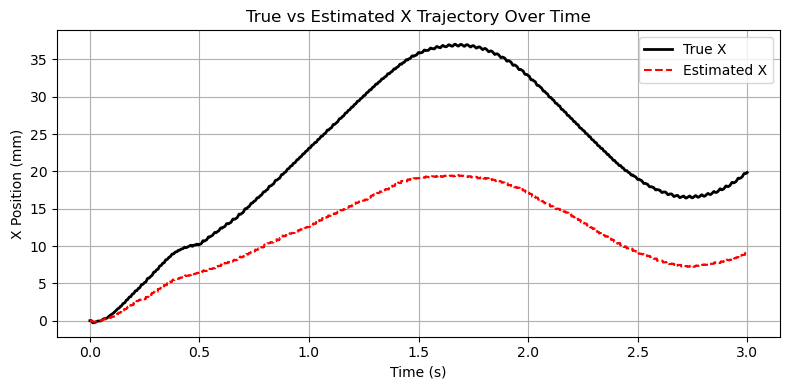

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Build time vector from controller trace length
times = np.arange(len(controller.position_trace)) * controller.timestep

# Extract estimated X positions
estimated = np.array(controller.position_trace)  # shape (N,2)
est_x = estimated[:, 0]

# Extract true X positions from obs_hist
true_x = []
for obs in obs_hist:
    # obs['fly'][0] is [x,y,z]
    pos = obs.get('fly', [[None, None, None]])[0]
    true_x.append(pos[0])
true_x = np.array(true_x)

# Ensure matching lengths
min_len = min(len(times), len(true_x))
times = times[:min_len]
est_x = est_x[:min_len]
true_x = true_x[:min_len]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(times, true_x, label='True X', color='black', linewidth=2)
plt.plot(times, est_x, label='Estimated X', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('X Position (mm)')
plt.title('True vs Estimated X Trajectory Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


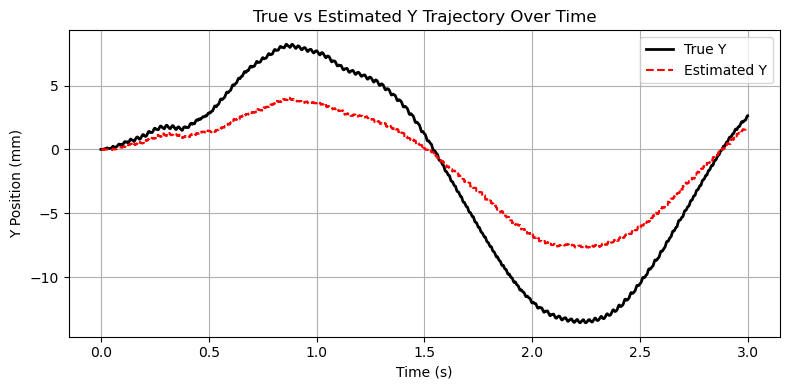

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Build time vector from controller trace length
times = np.arange(len(controller.position_trace)) * controller.timestep

# Extract estimated X positions
estimated = np.array(controller.position_trace)  # shape (N,2)
est_y = estimated[:, 1]

# Extract true X positions from obs_hist
true_y = []
for obs in obs_hist:
    # obs['fly'][0] is [x,y,z]
    pos = obs.get('fly', [[None, None, None]])[0]
    true_y.append(pos[1])
true_y = np.array(true_y)

# Ensure matching lengths
min_len = min(len(times), len(true_y))
times = times[:min_len]
est_y = est_y[:min_len]
true_y = true_y[:min_len]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(times, true_y, label='True Y', color='black', linewidth=2)
plt.plot(times, est_y, label='Estimated Y', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Y Position (mm)')
plt.title('True vs Estimated Y Trajectory Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


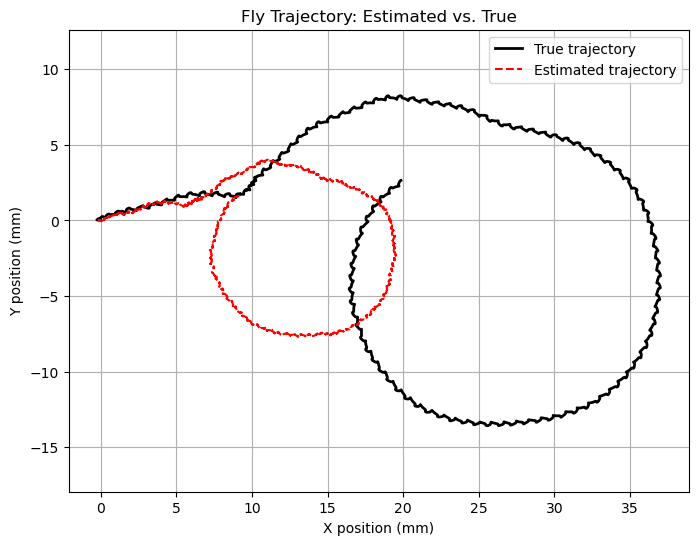

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Estimated trajectory
estimated = np.array(controller.position_trace)

# True trajectory: extract first row from obs["fly"] (x, y, z), keep only x and y
true_points = []
for obs in obs_hist:
    try:
        if "fly" in obs:
            pos = obs["fly"][0]  # First row: position
            if isinstance(pos, (list, tuple, np.ndarray)) and len(pos) >= 2:
                true_points.append([pos[0], pos[1]])
    except Exception:
        continue

true = np.array(true_points)

# Plot
plt.figure(figsize=(8, 6))
if len(true) > 0:
    plt.plot(true[:, 0], true[:, 1], label="True trajectory", color="black", linewidth=2)
if len(estimated) > 0:
    plt.plot(estimated[:, 0], estimated[:, 1], label="Estimated trajectory", color="red", linestyle="--", linewidth=1.5)






plt.xlabel("X position (mm)")
plt.ylabel("Y position (mm)")
plt.title("Fly Trajectory: Estimated vs. True")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


Plot x et y enb fct du temps 

[[0.00115301 0.00114451 0.00118006 0.00117751]
 [0.         0.         0.         0.        ]]


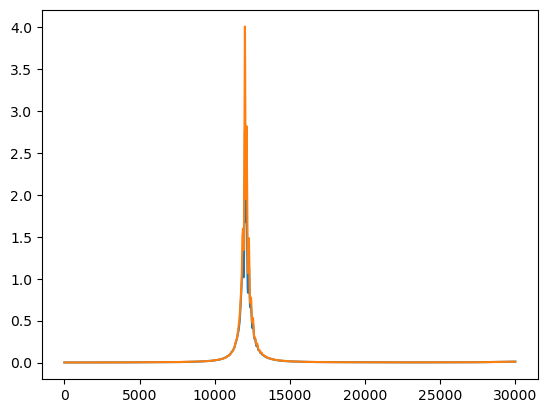

In [63]:
#plot of the odor intensity 
import matplotlib.pyplot as plt
import numpy as np

print(obs_hist[0]["odor_intensity"])    


     
odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]

plt.plot(odor_left, label="Left Odor Intensity")
plt.plot(odor_right, label="Right Odor Intensity")
